# NASBench-101

This colab accompanies [**NAS-Bench-101: Towards Reproducible Neural Architecture Search**](https://arxiv.org/abs/1902.09635) and the rest of the code at https://github.com/google-research/nasbench.

In this colab, we demonstrate how to use the dataset for simple benchmarking and analysis. The publicly available and free hosted colab instances are sufficient to run this colab.

## Load NASBench library and dataset

In [2]:
# Download the raw data (only 108 epoch data points, for full dataset,
# uncomment the second line for nasbench_full.tfrecord).

# !curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

# !git clone https://github.com/google-research/nasbench
# !pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api
%load_ext autoreload
%autoreload 2

import sys
import os
os.chdir('/home/yukaiche/pycharm/automl/search_policies/cnn/nasbench101')
sys.path.append("/home/yukaiche/pycharm/nasbench")
sys.path.append('/home/yukaiche/pycharm/automl')


from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasdata = api.NASBench('/home/yukaiche/pycharm/nasbench/nasbench_only108.tfrecord')


Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 44 seconds


In [3]:

from search_policies.cnn.search_space.nasbench101.nasbench_api_v2 import NASBench_v2
nasdata_v2 = NASBench_v2('/home/yukaiche/data/nasbench_only108.tfrecord', only_hash=False)


[0.38076125 0.76041522 0.75035755]
32
Cannot import graphviz package
Loading dataset from file... This may take a few minutes...
Loaded dataset in 44 seconds


# Test Graph generation from json style file.


In [4]:

import json
from search_policies.cnn.search_space.nasbench101.sampler import random_spec
from search_policies.cnn.search_space.nasbench101.nasbench_api_v2 import ModelSpec_v2
import search_policies.cnn.search_space.nasbench101.util as util 
# r_spec = random_spec(nasdata_v2)
# print(r_spec.ops[1:-1])
# load the graph.json
with open('/home/yukaiche/pycharm/nasbench/nasbench/scripts/graph_v4.json') as f:
    graph_json = json.load(f)

hashs = [h for h in graph_json.keys()]
_hash = hashs[-10]
print(graph_json[_hash])
# lists = graph_json[_hash]
# [i + 2 for i in lists[1]]
# available_ops=('conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3')

hash_v2 = ModelSpec_v2.load_from_list(graph_json[_hash])
print("hash v2 created graph", hash_v2)
query = nasdata.get_metrics_from_hash(_hash)
print("hash query from NasBench v1")
util.display_cell(query[0])
print("model_spec query from NasBench v1")
util.display_cell(nasdata.query(hash_v2))

[[[0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]], [-1, 2, 0, -2]]
hash v2 created graph Adjacent matrix: [[0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]] 
Ops: ['input', 'maxpool3x3', 'conv3x3-bn-relu', 'output']

hash query from NasBench v1
model_spec query from NasBench v1


In [5]:
# print('hash query from NasBench v2')
# util.display_cell(nasdata_v2.get_metrics_from_hash(_hash))
print("model_spec query from NasBench v2")
util.display_cell(nasdata_v2.query(hash_v2))
# fixed_stat, computed_stat = nasdata_v2.get_metrics_from_hash(_hash)
# util.display_cell(fixed_stat)
# util.display_cell(computed_stat)
# print(computed_stat[108][0])

# Check the output
# input graph_json is now bi-literal relationship.
hash_v2.model_spec_to_json() == graph_json[_hash]


model_spec query from NasBench v2


True

# Produce the ranking of NASBench based on hash.


In [12]:
NASBENCH_CONFIG = 'v4_e9_op3'
with open(f'/home/yukaiche/data/nasbench_all_graphs_{NASBENCH_CONFIG}.json', 'r') as f:
    all_graphs = json.load(f)


all_hashs = all_graphs.keys()
print('All models in NASBench', len(all_graphs))


All models in NASBench 91


In [13]:
import pandas as pd
all_hashs = [k for k in all_hashs]
hash_vs_valid_acc = {}
for _hash in all_hashs:
    d = nasdata_v2.query(ModelSpec_v2.load_from_list(all_graphs[_hash]))
    # print([k for k in d.keys()])
    acc = d['validation_accuracy']
    hash_vs_valid_acc[_hash] = acc
    # print(acc)

# print([k for k in hash_vs_valid_acc.keys()])

pd_hash = pd.DataFrame.from_dict(
    {'hash': [k for k in hash_vs_valid_acc.keys()],
     'validation_accuracy':[ hash_vs_valid_acc[new_k] for new_k in [k for k in hash_vs_valid_acc.keys()]]}
)
pd_hash.reset_index(inplace=True)
pd_hash.sort_values('validation_accuracy',inplace=True)
pd_hash.reset_index(inplace=True, drop=True)
print(pd_hash[:10])



   index                              hash  validation_accuracy
0     17  278a65c91e279624407615a84f3282c4             0.780616
1     53  79ac0ca945869f05b1fc34f4110f67d3             0.797977
2     55  7dadb571f060337fb22f22029a04228a             0.816506
3     33  47fb5adadfc9f8a75e3de789f7591943             0.819812
4     79  d1269d9156ddc027c40473008192958a             0.824486
5      8  168e95938db8e7c52112e58c0f292079             0.826723
6     32  471546730eff6ba24d163061e4029d13             0.829026
7      3  043721b9c7fe8c5fad811d47d83132ec             0.834034
8     29  3c325aea3e66b614c829c5169d038b80             0.835804
9      6  09fc2d10bdd6225e167a6f81a22a3f06             0.836138


In [16]:
new_dict = pd_hash.to_dict()
# with open('/home/yukaiche/data/nasbench_hash-rank_v7_e9_op3.json', 'w') as f:
#     json.dump(new_dict, f)
# print([k for k in new_dict.keys()])

only_hash = [new_dict['hash'][k] for k in sorted([v for v in new_dict['index'].values()])]
print(only_hash[:10])
with open(f'/home/yukaiche/data/nasbench_hash_rank_simple_{NASBENCH_CONFIG.replace("_", "-")}.json', 'w') as f:
    json.dump([new_dict['hash'][k] for k in sorted([v for v in new_dict['index'].values()])], f)

# Sanity check
util.display_cell(nasdata_v2.query(ModelSpec_v2.load_from_list(all_graphs['278a65c91e279624407615a84f3282c4'])))


['278a65c91e279624407615a84f3282c4', '79ac0ca945869f05b1fc34f4110f67d3', '7dadb571f060337fb22f22029a04228a', '47fb5adadfc9f8a75e3de789f7591943', 'd1269d9156ddc027c40473008192958a', '168e95938db8e7c52112e58c0f292079', '471546730eff6ba24d163061e4029d13', '043721b9c7fe8c5fad811d47d83132ec', '3c325aea3e66b614c829c5169d038b80', '09fc2d10bdd6225e167a6f81a22a3f06']


(array([ 1.,  0.,  1.,  0.,  2.,  3.,  6.,  0.,  0.,  0.,  0.,  0., 10.,
        16.,  2.,  2.,  4., 10., 15., 19.]),
 array([0.78061565, 0.78879373, 0.79697182, 0.8051499 , 0.81332798,
        0.82150607, 0.82968415, 0.83786224, 0.84604032, 0.8542184 ,
        0.86239649, 0.87057457, 0.87875266, 0.88693074, 0.89510882,
        0.90328691, 0.91146499, 0.91964308, 0.92782116, 0.93599925,
        0.94417733]),
 <a list of 20 Patch objects>)

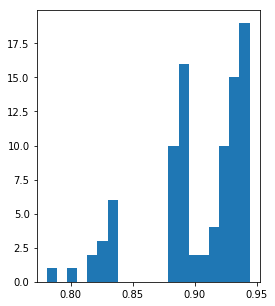

In [18]:
# Visualize the histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(4,5))
ax.hist(new_dict['validation_accuracy'].values(), bins = 20)


In [19]:
# Test sampling the data 
# Not random, but just take a bunch of from 
# sample a set of 30 hash, build their graph and train.
# put this funciton into the manual_define_sampled_search
from search_policies.cnn.search_space.nasbench101.sampler import manual_define_sampled_search
print(manual_define_sampled_search())

_hash = 'ef11a63e3dec4177d65648771c3689aa'

util.display_cell(nasdata_v2.query_hash(_hash))
print(nasdata_v2.hash_to_model_spec(_hash))


('"ef11a63e3dec4177d65648771c3689aa" "a2d021f626023241ae7268eb8260240c" "172b3b3d8163eb2f2ad63b5b6d7e214a" "523ac64c85d50533bbbb695d6f3c583f" "81a7f132d0d93078bf6f58ae660985e4" "538464bec1502be99fbfbd5200080caa" "018b46ecbd2d0cdc420cb4574383b694" "97a390a2cb02fdfbc505f6ac44a37228" "d885d701640a7d5fb1904bb5212b3200" "7b7924641b6ee467f82f37b3b7eb51dd" "dbb82f92411e951be3c3249eb118328b" "6c678b4d5c0bb786d69ba399c0ee6759" "42795b0b09cb57d2fab0f97d576d0ed3" "bbbcaeddb4d0782013a4aa63864f46d9" "253224d103e3c1099761405f2c965959" "ebea8be67d25fc825ce6ffe4276479f2" "ffa05e224fdf80254991a0b91865f593" "bd617b04c723cf1b7e63afae9b1963c2" "a84b1ca6851ea9ea913b7fbedcb47a94" "f2ff48f97a4f7b340b10f7600a062b5e" "73a74dee1d13b18a4d8bc03eb1156e5c" "1119da5413faccc8a6aec77d55d26fc7" "f8167cf8d4c0926fc9436a7a058b2b54" "7411b9803ffe264b406bb658440c8f63" "c98011952d1679b2a7e3999338ff4a13" "789eb4f52941c786ac64242606d379fb" "0a597cbfd44a59343135083788bd3c94" "b94e6efc2afbbcfb86607e534ffc1015" "208476d048a555195

# Node = 4 case to do sanity checking.

This is to test the use case while node = 4, in CNN, for soft-weight-sharing.


In [9]:
with open('/home/yukaiche/data/nasbench_all_graphs_v4_e9_op3.json', 'r') as f:
    all_graphs = json.load(f)


all_hashs = all_graphs.keys()
print('All models in NASBench', len(all_graphs))


All models in NASBench 91


In [24]:
from search_policies.cnn.search_space.nasbench101.model import NasBenchNet

net = NasBenchNet(3, nasdata_v2.hash_to_model_spec(_hash))

print(len(net.stacks))


INFO:tensorflow:vertex_channels: [128, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 512, 512, 512, 512, 1024]
INFO:tensorflow:vertex_channels: [1024, 512, 512, 512, 512, 1024]
INFO:tensorflow:vertex_channels: [1024, 512, 512, 512, 512, 1024]
3


INFO:tensorflow:vertex_channels: [128, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 128, 128, 128, 128, 256]
INFO:tensorflow:vertex_channels: [256, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 256, 256, 256, 256, 512]
INFO:tensorflow:vertex_channels: [512, 512, 512, 512, 512, 1024]
INFO:tensorflow:vertex_channels: [1024, 512, 512, 512, 512, 1024]
INFO:tensorflow:vertex_channels: [1024, 512, 512, 512, 512, 1024]


In [35]:

acell = net.stacks['stack0']['module0']
print(acell.dag)

import networkx as nx
model_spec = nasdata_v2.hash_to_model_spec(_hash)
dag = nx.from_numpy_matrix(model_spec.matrix, create_using=nx.DiGraph())
print(acell.execution_order.keys())
print(model_spec.matrix)


odict_keys(['vertex_1', 'vertex_2', 'vertex_3', 'vertex_4', 'output'])
[[0 1 0 0 0 0]
 [0 0 1 1 1 0]
 [0 0 0 1 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


In [39]:

for vert in nx.topological_sort(dag):
    print(vert)
    print(list(dag.predecessors(vert)))

print(nx.to_dict_of_dicts(dag))
print(nx.to_edgelist(dag))



nx.from_edgelist(genotype,create_using=nx.DiGraph())

0
[]
1
[0]
2
[1]
3
[1, 2]
4
[1, 2, 3]
5
[2, 4]
{0: {1: {'weight': 1}}, 1: {2: {'weight': 1}, 3: {'weight': 1}, 4: {'weight': 1}}, 2: {3: {'weight': 1}, 4: {'weight': 1}, 5: {'weight': 1}}, 3: {4: {'weight': 1}}, 4: {5: {'weight': 1}}, 5: {}}
[(0, 1, {'weight': 1}), (1, 2, {'weight': 1}), (1, 3, {'weight': 1}), (1, 4, {'weight': 1}), (2, 3, {'weight': 1}), (2, 4, {'weight': 1}), (2, 5, {'weight': 1}), (3, 4, {'weight': 1}), (4, 5, {'weight': 1})]
